# randomBasedDispatchModel
- @param `df_locations` : pd.Dataframe型の地理情報データ
- @param `df_bikes` : pd.Dataframe型の自転車データ
- @return `raodomBasedDispatchModel`

## solve()
- @param `df_request` : pd.Dataframe型のユーザーリクエスト
- @return `result` : 自転車IDと割り当てられたユーザーのキューインデックス

In [ ]:
import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
from pandas import DataFrame
from scipy.interpolate import PchipInterpolator

In [ ]:
# データの準備

'''locationID検索用CSV'''
df_locations = pd.read_csv('/content/taxi_zone_lookup_with_coordinates.csv')

# 最後の2行を除外
df_locations = df_locations.iloc[:-2]

print(df_locations.head())

   LocationID        Borough                     Zone service_zone   Latitude  \
0           1            EWR           Newark Airport          EWR  40.689531   
1           2         Queens              Jamaica Bay    Boro Zone  40.603994   
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone  40.865229   
3           4      Manhattan            Alphabet City  Yellow Zone  40.725102   
4           5  Staten Island            Arden Heights    Boro Zone  40.563700   

   Longitude  
0 -74.174462  
1 -73.835412  
2 -73.842739  
3 -73.979583  
4 -74.191603  


In [ ]:
'''自転車の集合'''
# ランダムシードを設定して、ランダムに10個選択
np.random.seed(42)
random_sample = df_locations.sample(n=100, replace=True)

# Bike IDを設定
random_sample['Bike ID'] = range(100)

# 緯度と経度をホームポジションとカレントポジションに設定
random_sample['Home Position'] = list(zip(random_sample['Latitude'], random_sample['Longitude']))
random_sample['Current Location'] = random_sample['Home Position']

# 結果のデータフレームを整形
B = random_sample[['Bike ID', 'Home Position', 'Current Location']]
B.set_index("Bike ID", inplace=True)

# DODatetimeカラムを追加して初期値をNaTに設定
B['DODatetime'] = pd.NaT

# データの中身を確認
B

<ipython-input-3-e610a7eb8667>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['DODatetime'] = pd.NaT


,Home Position,Current Location,DODatetime
Bike ID,,,
0,"(40.688584, -74.019375)","(40.688584, -74.019375)",NaT
1,"(40.7355189, -73.9840794)","(40.7355189, -73.9840794)",NaT
2,"(40.65285365742539, -73.91998230758563)","(40.65285365742539, -73.91998230758563)",NaT
3,"(40.6778708, -73.9684725)","(40.6778708, -73.9684725)",NaT
4,"(40.61394235958525, -73.98139265868924)","(40.61394235958525, -73.98139265868924)",NaT
...,...,...,...
95,"(40.76434708895304, -73.92352472468653)","(40.76434708895304, -73.92352472468653)",NaT
96,"(40.6770477, -73.8912474)","(40.6770477, -73.8912474)",NaT
97,"(40.717224, -74.011923)","(40.717224, -74.011923)",NaT


In [ ]:
'''ユーザーリクエストの集合'''

STARTING_DATE = '2023-01-01 0:00'
END_DATE = '2023-01-02 0:00'

# ParquetファイルのURL
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

# Parquetファイルを読み込む
df = pd.read_parquet(url)

# 指定されたカラムのみを含むデータフレームを取得
df_requests = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID']]

# データのフィルタリング
# 2023年1月1日以前のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] >= STARTING_DATE]
# 2023年2月1日以降のデータを削除
df_requests = df_requests[df_requests['tpep_pickup_datetime'] < END_DATE]

# ピックアップタイムの昇順で並び替え
df_requests = df_requests.sort_values(by='tpep_pickup_datetime')

# インデックスをリセット
df_requests = df_requests.reset_index(drop=True)

# フィルタリングされたデータの先頭を表示
print(df_requests.head())

# データフレームの情報を表示
print(df_requests.info())

  tpep_pickup_datetime tpep_dropoff_datetime  PULocationID  DOLocationID
0  2023-01-01 00:00:00   2023-01-01 00:08:00            42            41
1  2023-01-01 00:00:05   2023-01-01 00:26:27           249           186
2  2023-01-01 00:00:06   2023-01-01 00:05:44           125            68
3  2023-01-01 00:00:08   2023-01-01 00:11:24            42           244
4  2023-01-01 00:00:09   2023-01-01 00:15:10            79           231
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76752 entries, 0 to 76751
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   76752 non-null  datetime64[us]
 1   tpep_dropoff_datetime  76752 non-null  datetime64[us]
 2   PULocationID           76752 non-null  int64         
 3   DOLocationID           76752 non-null  int64         
dtypes: datetime64[us](2), int64(2)
memory usage: 2.3 MB
None


In [ ]:
# randomBasedDispatchModelクラスを定義
class randomBasedDispatchModel():
  def __init__(self, df_locations, df_bikes):
    self.df_locations = df_locations
    self.df_bikes = df_bikes


  '''LocationIDから経度と緯度をタプルで返す関数'''
  def _get_coordinates_by_location_id(self, location_id):
    row = self.df_locations[self.df_locations['LocationID'] == location_id]
    if not row.empty:
        latitude = row.iloc[0]['Latitude']
        longitude = row.iloc[0]['Longitude']
        # 緯度と経度が有効な数値であるかどうかを確認する
        if pd.notna(latitude) and pd.notna(longitude):
            return (latitude, longitude)
        else:
            return None
    else:
        return None


  '''利用可能な自転車の集合を返す関数'''
  def _get_available_bikes(
      self,
      current_time: datetime = None
  ) -> np.ndarray:
      # current_timeがNoneの場合、現在時刻を取得
      # 本番運用時はcurrent_timeを利用しない
      if current_time is None:
          current_time = datetime.now()
      else:
          current_time = pd.to_datetime(current_time)
          # current_timeを単一のdatetimeオブジェクトに変更
          # current_time = current_time.iloc[0]  # DataFrameの最初の要素を取得

      # print("self.df_bikes['DODatetime']: ", self.df_bikes['DODatetime'])
      # print("current_time: ", current_time)

      # 利用可能な自転車を1、不可能な自転車を0とする行列を作成
      available_bikes = (self.df_bikes['DODatetime'].isna() | (self.df_bikes['DODatetime'] < current_time)).astype(int)
      # available_bikes = self.df_bikes['DODatetime'].apply(
      #     lambda x: 1 if pd.isna(x) or (x < pd.to_datetime(current_time)) else 0
      # )
      # print('-----available_bikes.values-----')
      # print(available_bikes.values)
      return available_bikes.values


  '''割り当て成功後の自転車ステータスの更新'''
  def _update_bike_status(
      self,
      bike_assignment,
      df_requests
  ):
      for b, j in bike_assignment:
          # jのtpep_dropoff_datetimeを取得するし自転車ステータス更新する
          # df_requestsのインデックスjに対応する行を取得
          print('-----df_requests.loc[j]-----')
          print(df_requests.loc[j])
          request_row = df_requests.loc[j]
          self.df_bikes.at[b, 'DODatetime'] = request_row['tpep_dropoff_datetime']
          # jのDOLocationIDを取得して自転車のCurrent Locationを更新する
          self.df_bikes.at[b, 'Current Location'] = self._get_coordinates_by_location_id(request_row['DOLocationID'])


  '''結果出力用メソッド'''
  def _print_results(self, result_dict):
      # 辞書型のそれぞれのデータに対して"key: value"形式で出力する
      for key, value in result_dict.items():
          print(f"{key}: {value}")
      # print("-------------------------------------------------------")

  '''ランダム割り当てメイン処理'''
  '''retun bike_assignment = [(b, j)]'''
  def solve(self, df_request) -> list:
    # 利用可能な自転車を取得する
    # ipdb.set_trace()  # ブレークポイントを設定
    current_time = df_request.iloc[-1]['tpep_pickup_datetime']
    available_bikes = self._get_available_bikes(current_time)
    print(available_bikes)

    if not available_bikes.any():
        print("No available bikes.")
        return []

    # 利用可能な自転車のインデックスを取得
    available_bike_indices = np.where(available_bikes == 1)[0]

    # リクエスト数(1つ)と利用可能な自転車数を比較して、少ない方を割り当て数とする
    # num_assignments = 1
    num_assignments = min(len(df_request), len(available_bike_indices))

    # ランダムなインデックスを生成
    selected_bike_indices = np.random.choice(available_bike_indices, size=num_assignments, replace=False)

    # 結果を格納するリスト
    bike_assignment = []
    for i in range(num_assignments):
        # 自転車IDとリクエストのインデックスをタプルで結果に追加
        bike_assignment.append((self.df_bikes.index[selected_bike_indices[i]], df_request.index[i]))

    # _print_results()に結果を渡して出力する
    result_dict = {
        "bike_assignment": bike_assignment,
    }
    self._print_results(result_dict) #←モデル検証・デバッグ用

    # 自転車ステータスを更新
    self._update_bike_status(bike_assignment, df_request)
    return bike_assignment


# 動作確認

In [ ]:
# randomBasedDispatchModelの初期化・インスタンス作成
randomBasedDispatchModel = randomBasedDispatchModel(df_locations, B)

In [ ]:
def calculate_total_distance(df):
    """
    データフレームからホームポジションとカレントポジションのノルムの総和を計算する関数。

    :param df: ホームポジションとカレントポジションを含むデータフレーム
    :return: 距離の総和
    """
    total_distance = 0
    for _, row in df.iterrows():
        home_pos = np.array(row['Home Position'])
        current_loc = np.array(row['Current Location'])
        distance = np.linalg.norm(home_pos - current_loc)
        total_distance += distance
    return total_distance

In [ ]:
# モデリングするためにユーザーリクエストデータを整形する

# tpep_pickup_datetimeをdatetime型に変換
df_requests['tpep_pickup_datetime'] = pd.to_datetime(df_requests['tpep_pickup_datetime'])
df_requests['tpep_dropoff_datetime'] = pd.to_datetime(df_requests['tpep_dropoff_datetime'])

# リクエストデータを一分ごとに分割
start_time = df_requests['tpep_pickup_datetime'].min()
end_time = df_requests['tpep_pickup_datetime'].max()
print(f"リクエストの開始時間：{start_time}")
print(f"リクエストの終了時間：{end_time}")
print(f"リバランスコスト初期値：{calculate_total_distance(B)}")

# マッチングプロセスのログデータ収集用時系列データ
time_series_log_data = []

# df_requestsを一行ずつ処理
for index, request_row in df_requests.iterrows():
    current_time = request_row['tpep_pickup_datetime']
    print(f"Time: {current_time}")

    # 現在のリクエストを抽出
    J = df_requests.iloc[[index]]  # 現在の行をDataFrameとして抽出
    # print(J)

    # PULocationIDまたはDOLocationIDが262より大きい場合は不正なリクエストとしてエラー文を出力して次の処理へスキップする
    if J['PULocationID'].values[0] > 262 or J['DOLocationID'].values[0] > 262:
        print("Invalid request. PULocationID or DOLocationID is greater than 262.")
        print("-------------------------------------------------------")
        continue

    # solve()を実行
    try:
        bike_assignment = randomBasedDispatchModel.solve(J)
    except RuntimeError:
        bike_assignment = []
        print("No feasible solution was found.")
        print("-------------------------------------------------------")

    # 自転車占有率を計算する
    available_bikes = randomBasedDispatchModel._get_available_bikes(current_time)
    bikes_occupied_rate = 1 - available_bikes.sum() / len(available_bikes)
    print(f"Bikes Occupied Rate: {bikes_occupied_rate}")

    # マッチング成功率を計算する
    matching_success_rate = len(bike_assignment) / len(J)
    print(f"Matching Success Rate: {matching_success_rate}")

    # 自転車の再配置コストを計算する
    rebalance_cost = calculate_total_distance(B)
    print(f"Rebalance Cost: {rebalance_cost}")
    print("-------------------------------------------------------")

    # ログ出力
    time_series_log_data.append({
        'time': current_time,
        'matching_success_rate': matching_success_rate,
        'bikes_occupied_rate': bikes_occupied_rate,
        'rebalance_cost': rebalance_cost
    })


Streaming output truncated to the last 5000 lines.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
No available bikes.
Bikes Occupied Rate: 1.0
Matching Success Rate: 0.0
Rebalance Cost: 13.867815081393738
-------------------------------------------------------
Time: 2023-01-01 23:43:20
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
No available bikes.
Bikes Occupied Rate: 1.0
Matching Success Rate: 0.0
Rebalance Cost: 13.867815081393738
-------------------------------------------------------
Time: 2023-01-01 23:43:24
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

In [ ]:
# 自転車のステータスを確認
B

,Home Position,Current Location,DODatetime
Bike ID,,,
0,"(40.688584, -74.019375)","(40.7644228, -73.9923918)",2023-01-02 06:46:57
1,"(40.7355189, -73.9840794)","(40.78366657018949, -73.94764843602209)",2023-01-02 00:03:00
2,"(40.65285365742539, -73.91998230758563)","(40.841370809362544, -73.93958583991703)",2023-01-02 00:07:10
3,"(40.6778708, -73.9684725)","(40.7360717, -73.9901888)",2023-01-02 00:01:53
4,"(40.61394235958525, -73.98139265868924)","(40.7397134, -74.0096709)",2023-01-02 00:04:15
...,...,...,...
95,"(40.76434708895304, -73.92352472468653)","(40.72105485, -73.93046893263465)",2023-01-02 00:06:43
96,"(40.6770477, -73.8912474)","(40.717224, -74.011923)",2023-01-02 00:12:51
97,"(40.717224, -74.011923)","(40.77104218830793, -73.98510402538086)",2023-01-02 00:01:05


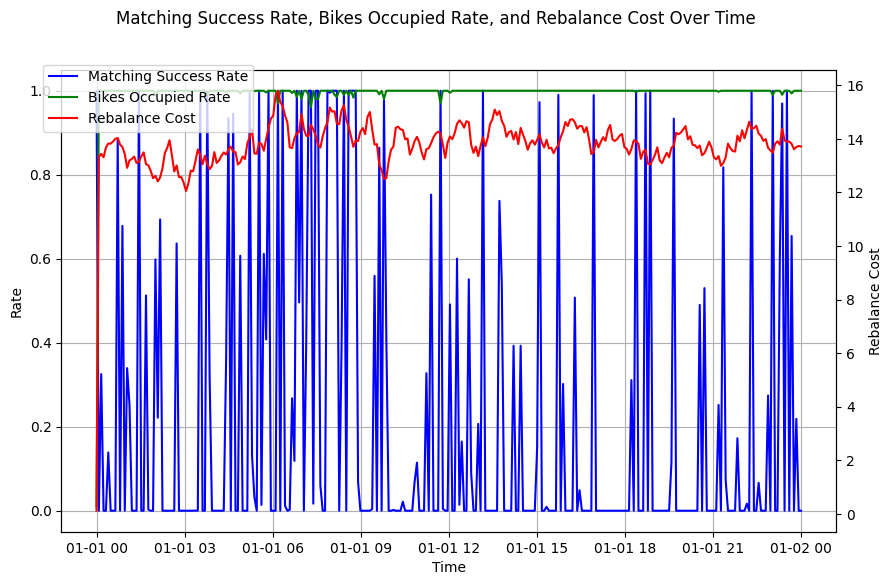

In [ ]:
# 自転車の割り当て成功率と占有率とリバランスコストの関係をグラフ化する

# ログデータをデータフレームにコンバートする
df_time_series = pd.DataFrame(time_series_log_data)

# 時間データを数値に変換
df_time_series['time'] = pd.to_numeric(df_time_series['time']) # Convert datetime to numeric
df_time_series.sort_values('time', inplace=True) # Sort by time
df_time_series.drop_duplicates(subset='time', inplace=True) # Remove duplicates
time = df_time_series['time'].values / 1e9  # 秒に変換

# 補間のための新しい時間データを作成
time_new = np.linspace(time.min(), time.max(), 300)

# PCHIP補間
pchip_matching_success_rate = PchipInterpolator(time, df_time_series['matching_success_rate'])
matching_success_rate_smooth = pchip_matching_success_rate(time_new)

pchip_bikes_occupied_rate = PchipInterpolator(time, df_time_series['bikes_occupied_rate'])
bikes_occupied_rate_smooth = pchip_bikes_occupied_rate(time_new)

pchip_rebalance_cost = PchipInterpolator(time, df_time_series['rebalance_cost'])
rebalance_cost_smooth = pchip_rebalance_cost(time_new)

# プロット
fig, ax1 = plt.subplots(figsize=(10, 6))

# 新しい時間データをDateTimeに変換してプロット
time_new_datetime = pd.to_datetime(time_new * 1e9)

# 左側のY軸に割り当て成功率と自転車の占有率をプロット
ax1.plot(time_new_datetime, matching_success_rate_smooth, label='Matching Success Rate', color='b')
ax1.plot(time_new_datetime, bikes_occupied_rate_smooth, label='Bikes Occupied Rate', color='g')
ax1.set_xlabel('Time')
ax1.set_ylabel('Rate', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# 右側のY軸にリバランスコストをプロット
ax2 = ax1.twinx()
ax2.plot(time_new_datetime, rebalance_cost_smooth, label='Rebalance Cost', color='r')
ax2.set_ylabel('Rebalance Cost', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# グラフのタイトルと凡例の設定
fig.suptitle('Matching Success Rate, Bikes Occupied Rate, and Rebalance Cost Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

ax1.grid(True)

plt.show()

# 最終自転車分布

In [ ]:
'''ユーザーの位置と自転車の位置をプロットする関数'''
def plot_users_and_bikes(
    user_locations: np.ndarray,
    bike_locations: np.ndarray,
    latitude_range: tuple[float, float],  # 描画範囲 (緯度)
    longitude_range: tuple[float, float],  # 描画範囲 (経度)
):
    m = folium.Map(
        [sum(latitude_range) / 2, sum(longitude_range) / 2],
        tiles="OpenStreetMap",
        zoom_start=11,
    )

    for latitude, longitude in user_locations:
        folium.Marker(
            location=(latitude, longitude),
            icon=folium.Icon(icon="user", prefix="fa", color="orange"),
        ).add_to(m)

    for latitude, longitude in bike_locations:
        folium.Marker(
            location=(latitude, longitude),
            icon=folium.Icon(icon="bicycle", prefix="fa", color="green"),
        ).add_to(m)

    return m

In [ ]:
# latitudeカラムとlongitudeカラムの最大値と最小値を取得
latitude_max = df_locations['Latitude'].max()
latitude_min = df_locations['Latitude'].min()
longitude_max = df_locations['Longitude'].max()
longitude_min = df_locations['Longitude'].min()

# 結果を表示
print(f"Latitude: max = {latitude_max}, min = {latitude_min}")
print(f"Longitude: max = {longitude_max}, min = {longitude_min}")

Latitude: max = 40.908178, min = 40.52825085411132
Longitude: max = -73.7115199, min = -74.23462644152289


In [ ]:
# NYC
latitude_range = (latitude_min - 0.1, latitude_max + 0.1)
longitude_range = (longitude_min - 0.1, longitude_max + 0.1)
print(latitude_range)
print(longitude_range)

current_locations = B['Current Location'].values
print(type(current_locations))
print(current_locations)

(40.42825085411132, 41.008178)
(-74.33462644152289, -73.6115199)
<class 'numpy.ndarray'>
[(40.7644228, -73.9923918) (40.78366657018949, -73.94764843602209)
 (40.841370809362544, -73.93958583991703) (40.7360717, -73.9901888)
 (40.7397134, -74.0096709) (40.7595077, -73.9841594)
 (40.69329057428703, -73.98567553195534)
 (40.78366657018949, -73.94764843602209) (40.8692579, -73.9204949)
 (40.796551198508986, -73.96843152636832) (40.7827725, -73.9653627406542)
 (40.74644799901946, -74.00141244627002) (40.717224, -74.011923)
 (40.7997764, -73.9677716) (40.7212687, -73.9836882)
 (40.71089736029504, -73.81372701679426)
 (40.79028734693419, -73.94786017196304)
 (40.78366657018949, -73.94764843602209) (40.659097, -73.95468)
 (40.723100900000006, -73.84661252338407)
 (40.84591775, -73.92984478686536) (40.7110166, -74.0169369)
 (40.7720145, -73.9302673) (40.807837000000006, -73.90642492860718)
 (40.7212687, -73.9836882) (40.7251022, -73.9795833)
 (40.67553311670336, -73.94403751076791)
 (40.7648215

In [ ]:
plot_users_and_bikes([], current_locations, latitude_range, longitude_range)

In [ ]:
# ログのCSV出力
from google.colab import files
filename =  "result_by_randomBasedDispatchModel_100.csv"
df_time_series.to_csv(filename, encoding = 'utf-8-sig')
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>